In [10]:
import matplotlib.pyplot as plt
from utils import tensor2image

def plot_images(images_list, title):
    fig, axs = plt.subplots(1, len(images_list), figsize=(20, 5))
    for idx, xt in enumerate(images_list):
        axs[idx].set_title(r'$x_{t}$'.replace("t",f"{idx}"))
        axs[idx].imshow(tensor2image(xt))
    fig.tight_layout()

# Ilustraciones

https://docs.google.com/presentation/d/17n1ny0yfbZFvHQFiFKhpYaI_bxG_EggdmvHJ6XIIuXE/edit?usp=sharing

# A Diffusion Model from Scratch in Pytorch

**Sources:**
- Github implementation [Denoising Diffusion Pytorch](https://github.com/lucidrains/denoising-diffusion-pytorch)
- Niels Rogge, Kashif Rasul, [Huggingface notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=3a159023)
- Papers on Diffusion models ([Dhariwal, Nichol, 2021], [Ho et al., 2020] ect.)


## Basics about Probablistics:

I have a joint distribution $ p(x,y) $, I can compute the marginall distribution over a certain random variable $x$ employgin the following equation.
$$ p(x) = \int{p(x,y)dy} $$

Employing the Bayes's Theorem $p(x,y) = p(x|y)p(y) = p(y|x)p(x)$, we can show:
$$ p(x) = \int{p(x|y)p(y)dy} $$

## Forward Process:

Chain rule's in probability $ q(a,b,c) = q(a) \cdot q(b|a) \cdot q(c|a,b) $

Probability distribution in forward process to $q(z_1,z_2|x)$ and because it's a Markov Process $q(z_2|z_1,x) = q(z_2|z_1)$:
\begin{align}
    q(z_1,z_2 | x) &= q(z_1|x) \cdot q(z_2|z_1,x) \\
                   &= q(z_1|x) \cdot q(z_2|z_1)
\end{align} 


Probability distribution in forward process to $q(z_{1...T}|x)$:

\begin{align}
    q(z_{1 ... T} | x) &= q(z_1|x) \cdot q(z_2|z_1) ... q(z_T|z_{T-1}) \\
                       &= q(z_1|x) \prod_{s=2}^{T}{q(z_s|z_{s-1})} 
\end{align}


We want to compute $q(z_{t-1}| z_t)$ because we do know $q(z_{t}| z_{t-1})$, so the question is, how?. Well we can use the bayes equation:

$$ q(z_{t-1}| z_{t}) = \frac{ q(z_t|z_{t-1}) \cdot q(z_{t-1})}{ q(z_t)} \propto q(z_t|z_{t-1}) \cdot q(z_{t-1}) $$

But we can't compute $q(z_t)$ or $q(z_{t-1})$, because to compute that we can start from the probability distribution $q(z_{1...T},x)$, and make some marginalization:

\begin{align}

q(z_t) &= \int{\int{q(z_{1...t-1},x) dz_{1...t-1}} dx} \\
       &= \int{\int{q(z_{1...t-1}|x) Pr(x) dz_{1...t-1}} dx} \\
       &= \int{q(z_{t-1}|x) Pr(x) dz_{t-1}} dx
\end{align}

We do knnow $q(z_t|x)$ but don't know $Pr(x)$ so, it's imposible to compute $q(z_t)$.

In the other hand we can compute $q(z_{t-1}|z_t,x)$, because applying the Bayes Theorem, all elements are "conocidos":

\begin{align}
q(z_{t-1}| z_t , x) &= \frac{ q(z_t | z_{t-1},x) \cdot q(z_{t-1} | x) }{ q(z_t|x) } \\  
                    &= \frac{ q(z_t | z_{t-1}) \cdot q(z_{t-1} | x) }{ q(z_t|x) } \\ 
                    &\propto  q(z_t | z_{t-1}) \cdot q(z_{t-1} | x) \\   
\end{align}




In [4]:
# Librerias

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from torchvision import transforms

In [8]:
# Implementación de las ecuaciones

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)


$$ \alpha_t = 1 - \beta_t$$

$$ \bar{\alpha}_{t} = \prod_{s=1}^{t} {\alpha_{s}} $$

$$ x_t = \sqrt{ \bar{\alpha}_t } \cdot x_{0} + \sqrt{1 - \bar{\alpha_t}} \cdot \epsilon $$

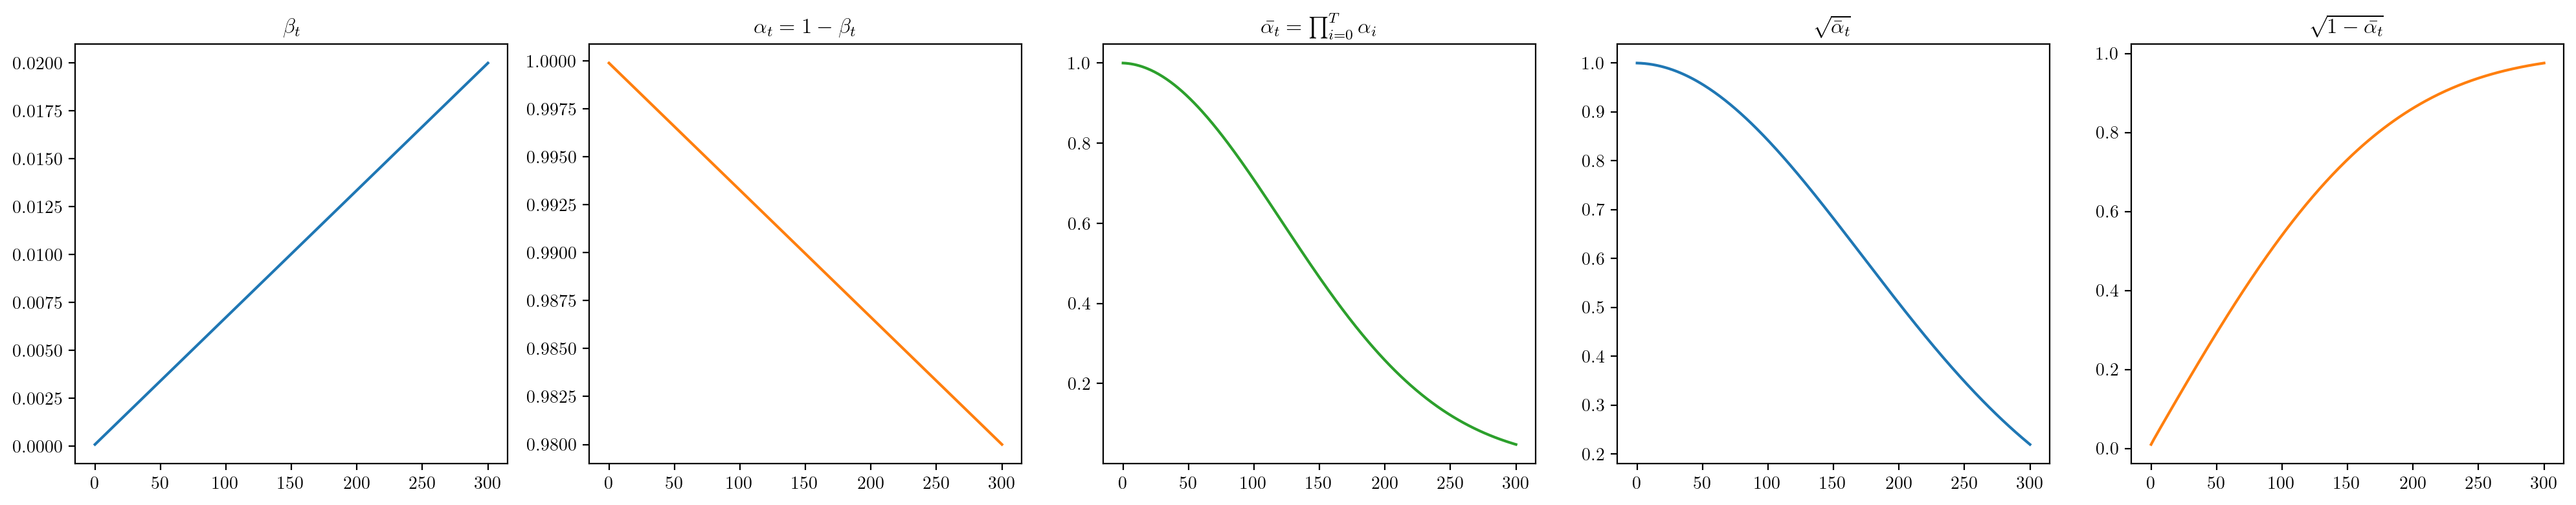

In [3]:
# Para dibujar las ecuaciones anteriores

plt.rcParams['text.usetex'] = True
plt.rcParams['savefig.dpi'] = 300
plt.rcParams["figure.dpi"] = 200

# TO SHOW WHAT'S HAPPENING ??? ...........

time = np.linspace(0,T,T)

fig, axs = plt.subplots(1, 5, figsize=(20, 4))
axs[0].plot(time, betas.numpy())
axs[0].set_title(r'$\beta_{t}$')

axs[1].plot(time, alphas.numpy(), 'tab:orange')
axs[1].set_title(r'$\alpha_{t} = 1 - \beta_{t}$')

axs[2].plot(time, alphas_cumprod.numpy(), 'tab:green')
axs[2].set_title(r'$ \bar{\alpha_{t}} = \prod_{i=0}^{T} {\alpha_{i}}$')

# axs[0, 3].plot(time, sqrt_recip_alphas.numpy(), 'tab:red')
# axs[0, 3].set_title(r'$\sqrt{1 / \alpha_{t}}$')

axs[3].plot(time, sqrt_alphas_cumprod.numpy())
axs[3].set_title(r'$ \sqrt{ \bar{\alpha}_t } $')

axs[4].plot(time, sqrt_one_minus_alphas_cumprod.numpy(), 'tab:orange')
axs[4].set_title(r'$ \sqrt{1 - \bar{\alpha_t}} $')

# axs[1, 2].plot(time, posterior_variance.numpy(), 'tab:green')
# axs[1, 2].set_title(r'$ \beta \cdot {1 - \sqrt{1 - \hat{\alpha_{t-1} } } }$')

fig.tight_layout() 
plt.show()

In [6]:
from utils import *
import numpy as np

def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )

    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

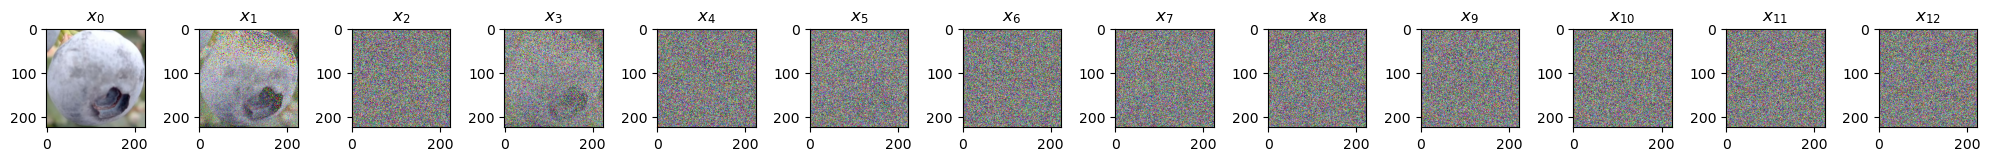

In [11]:
# calculando el forward-process, se comienza con x_0 y se calcula para t=[49,99,149,199,249,299], cada uno de estos se almacena en history
x_0 = image2tensor(Image.open('./blueberry/AZUL/AZUL(120).jpg'))
history = [x_0]

noise_ = []
img_ = []

for idx in range(1, 7):
    t = torch.Tensor([idx * 50 - 1]).type(torch.int64)
    img, noise = forward_diffusion_sample(x_0, t)
    history.append(img)
    history.append(noise)

    noise_.append(img)
    img_.append(noise)


# se dibuja lo que se ha almacenado en history
# fig, axs = plt.subplots(1, len(history), figsize=(20, 5))
# for idx, xt in enumerate(history):
#     axs[idx].set_title(r'$x_{t}$'.replace("t",f"{idx * 50}"))
#     axs[idx].imshow(tensor2image(xt))
# fig.tight_layout()
    
plot_images(history,title='')
# plot_images(img_[0:2],title='')
# plot_images(noise_[0:2],title='')

## Reverse Process:

El proceso inverso, consiste en convertir $z_{T}$ en $x$, para esto se necesita definir qué distribución de probabilidad se va a emplear para relacionar $q(z_{t-1}|z_t)$. Esta distribución de probabilidad, es compleja de calcular. En lugar de buscar esto, se va a buscar definir una distribución $p(z_{t-1}|z_{t}, \phi_{t})$. La "joint-distribution" de la variable observada $x$ y las variables latentes ${z_t}$ se define a continuación:

$$
p(x,z_{1...T}|\phi_{1...T}) = p(x|z_1,\phi_{1...T}) \cdot p(z_1|z_2,\phi_{2...T}) \cdot p(z_2|z_3,\phi_{3...T}) ... p(z_{T-1}|z_T,\phi_{T}) \cdot p(z_T)
$$

Como se trata de un proceso de Markov $ p(z_{t-1}|z_t,\phi_{t...T}) = p(z_{t-1}|z_t,\phi_t)$. Reescribiendo la ecuación anterior:

\begin{align}
p(x,z_{1...T}|\phi_{1...T}) &= p(x|z_1,\phi_1) \cdot p(z_1|z_2,\phi_2) \cdot p(z_2|z_3,\phi_3) ... p(z_{T-1}|z_T,\phi_{T}) \cdot p(z_T) \\
                            &= p(x|z_1,\phi_1) \prod_{k=1}^{T} p(z_k|z_{k+1},\phi_{k+1}) \cdot p(z_T)
\end{align}

El valor de $p(x|\phi_{1...T})$ es calculando marginalizando la distribución conjunta, como sigue:

\begin{align}
p(x|\phi_{1...T}) = \int{p(x,z_{1...T}|\phi_{1...T})} dz_{1...T}
\end{align}

Finalmente el modelo es entrenado para maximizar la log-likelihood de la información $\{ x_i \}$ de entrenamiento, con respecto a los parametros $\phi$.

$$
\hat{\phi}_{1...T} = \argmax_{\phi_{1...T}}{ \left[ \sum_{i=1}^{I} { log(p(x_{i}|\phi_{i...T}))  }  \right]}
$$



Let's test it on our dataset ...

In [7]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

IMG_SIZE = 64
BATCH_SIZE = 128

torchvision.datasets

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1]
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
    ]
    data_transform = transforms.Compose(data_transforms)

    train = torchvision.datasets.Flowers102(root=".", download=True,
                                         transform=data_transform)

    test = torchvision.datasets.Flowers102(root=".", download=True,
                                         transform=data_transform, split='test')
    return torch.utils.data.ConcatDataset([train, test])

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

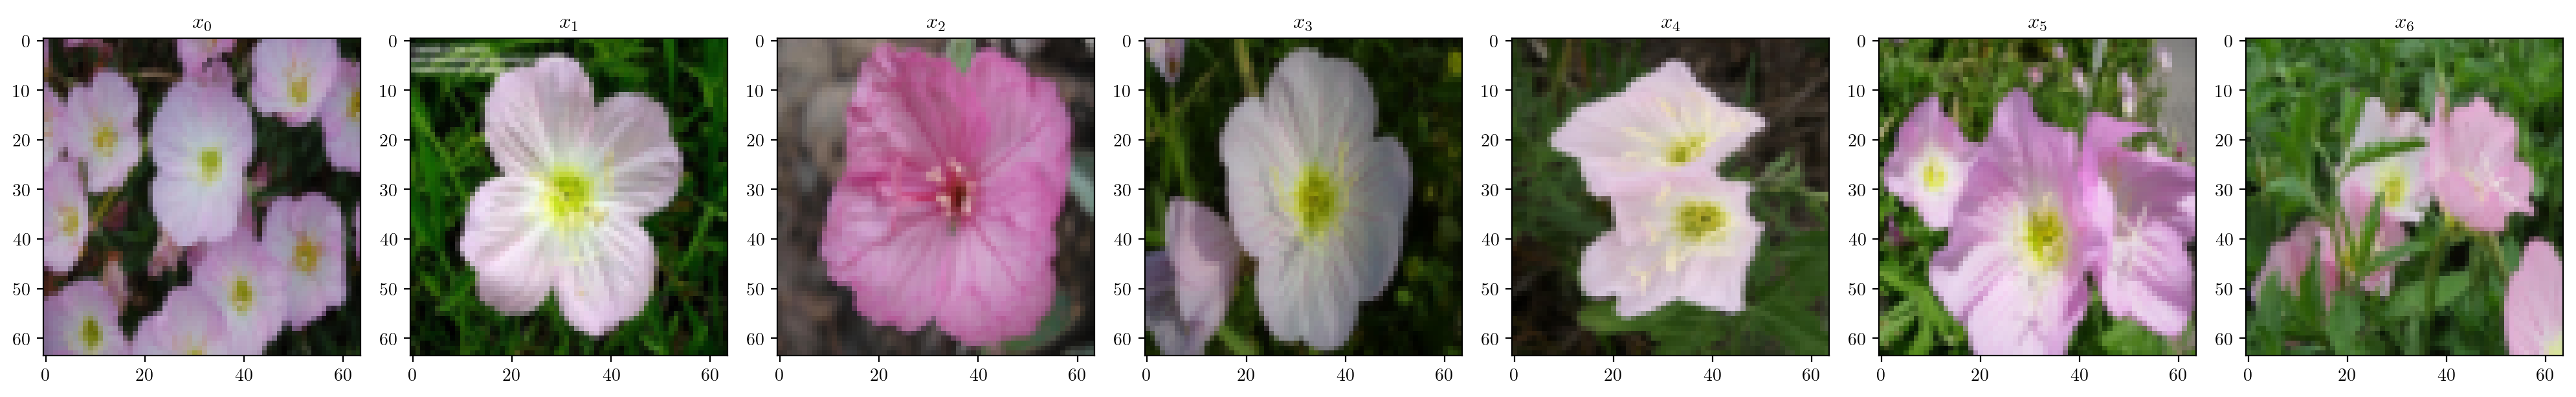

In [8]:
images = []
for i in range(7):
    image, category = dataloader.dataset[i]
    images.append(image)
plot_images(images,title='')

## Step 2: The backward process = U-Net



For a great introduction to UNets, have a look at this post: https://amaarora.github.io/2020/09/13/unet.html.


**Key Takeaways**:
- We use a simple form of a UNet for to predict the noise in the image
- The input is a noisy image, the ouput the noise in the image
- Because the parameters are shared accross time, we need to tell the network in which timestep we are
- The Timestep is encoded by the transformer Sinusoidal Embedding
- We output one single value (mean), because the variance is fixed


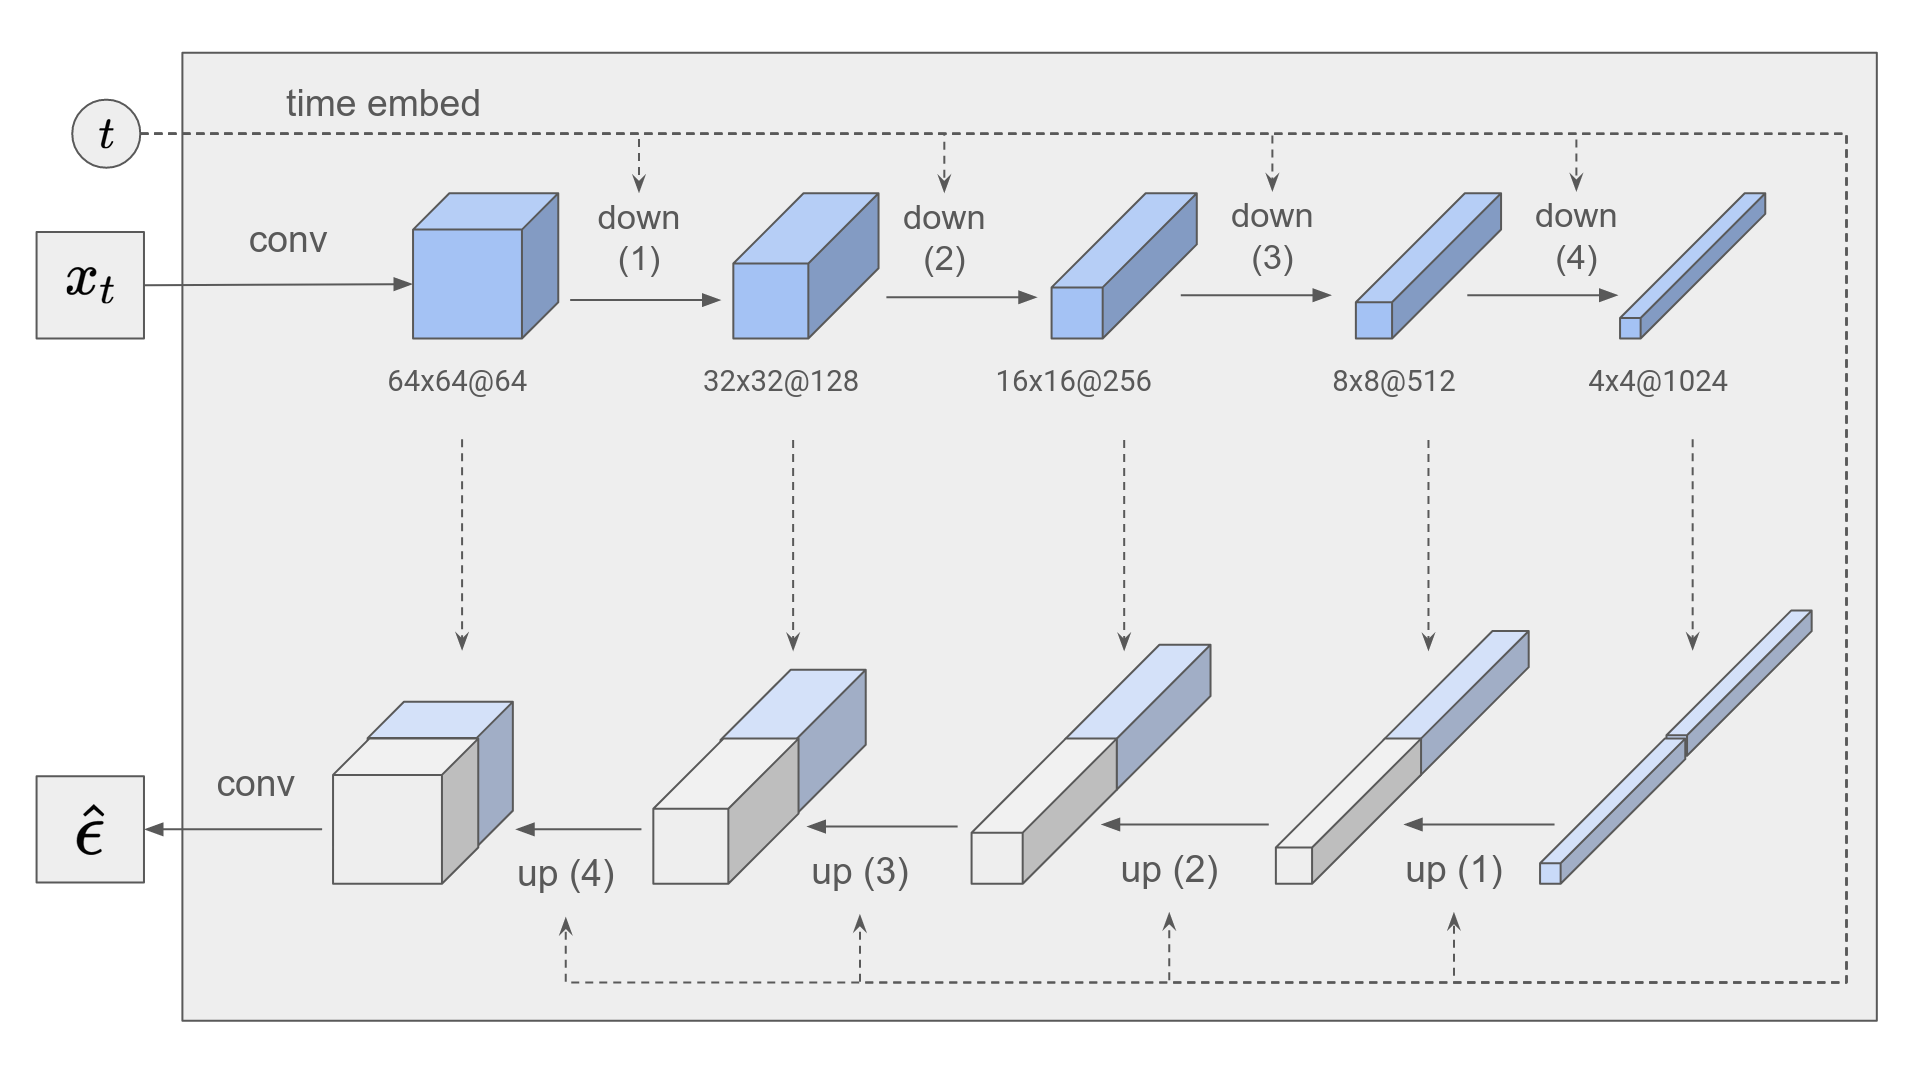

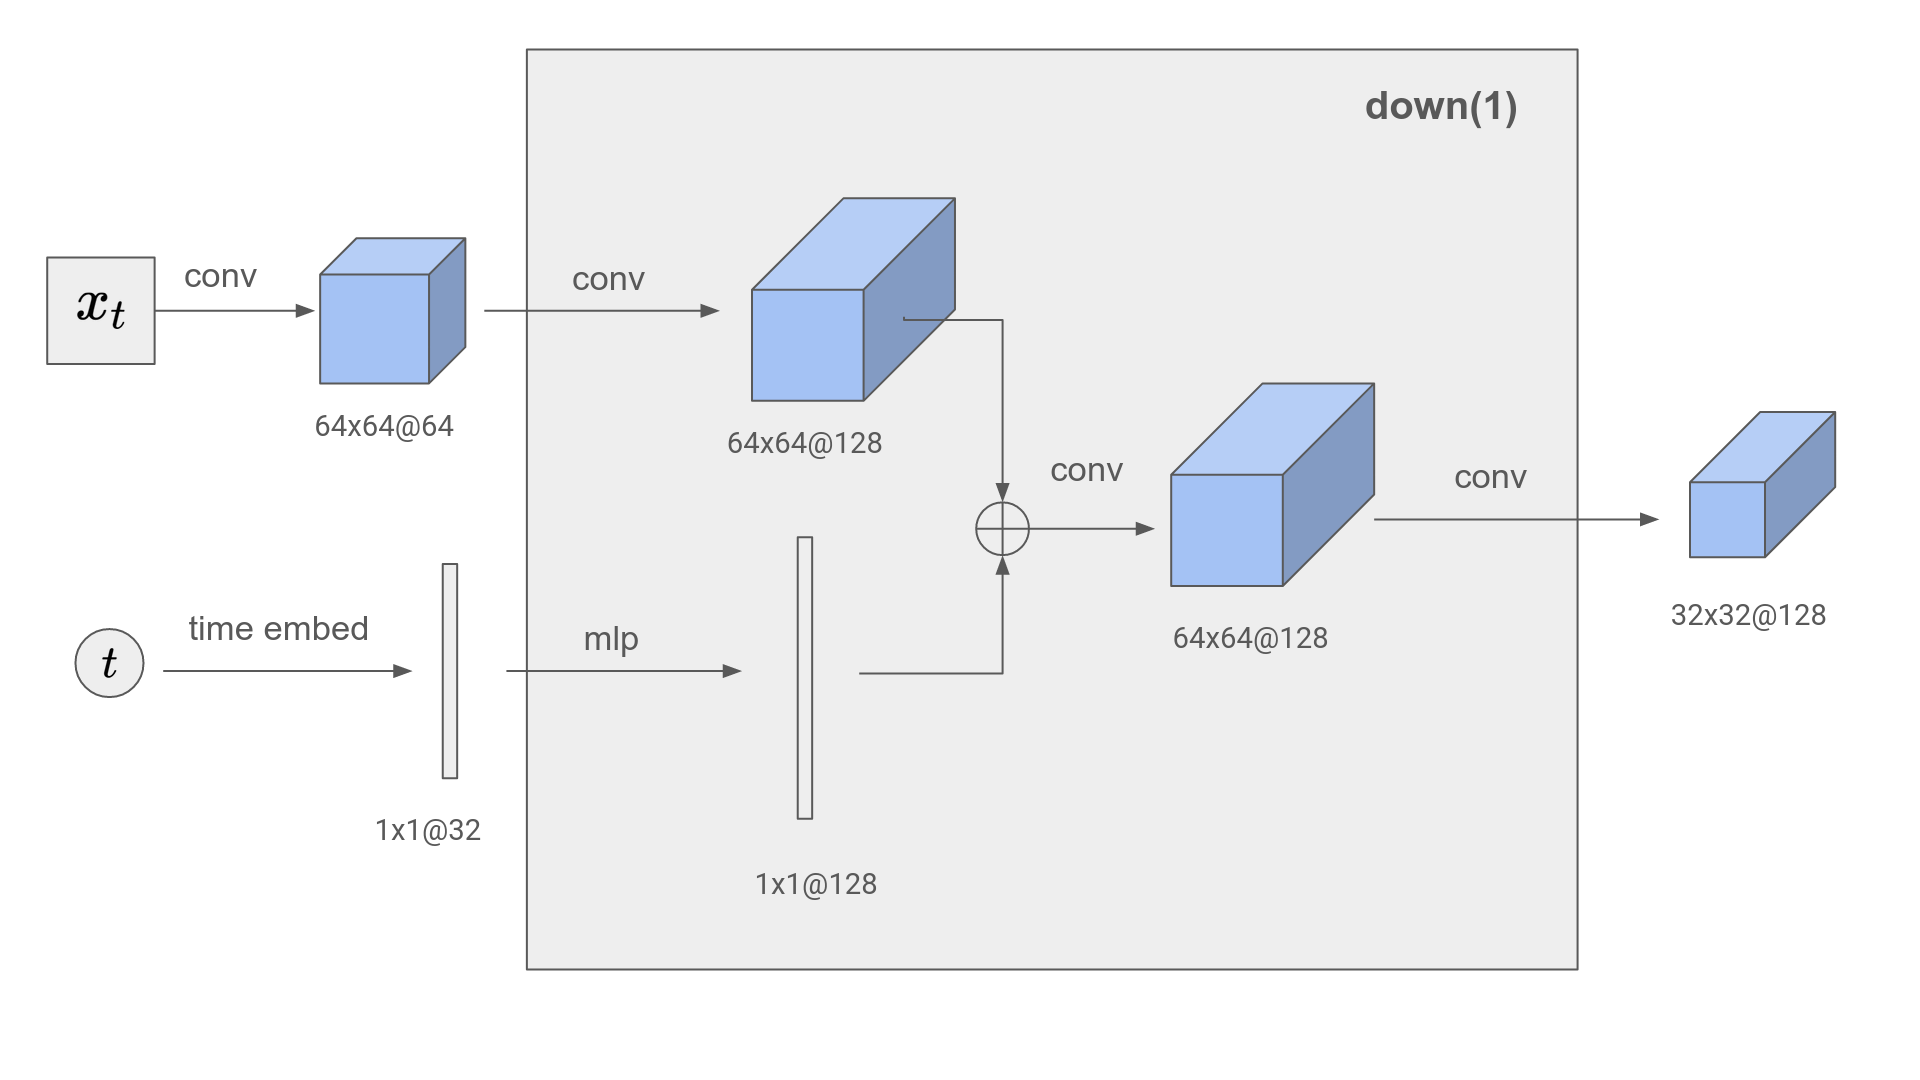

Given a specific $x_t$  and $t$ obtained from the current batch during the training loop. The following is the set of equations that are used to implement the **down** block, $f^{3\times3}$ denotes a convolutional neural network wich uses relu as activation function, $MLP$ represent a multilayer perceptron that also uses relu as activation function.

\begin{align}
&t_{emb} = MLP(t) \\
&h_{1} = BN(f_{relu}^{3\times3}(x_t)) \\
&h_{2} = BN(f_{relu}^{3\times3}( h_1 \oplus t_{emb} )) \\
&h_{out} = f^{4\times4}(h_2)
\end{align}

In [ ]:

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)

        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t, ):

        print("Input:", "t", list(t.shape), "," "x", list(x.shape))
        
        # First Conv
        
        h = self.bnorm1(self.relu(self.conv1(x)))
        print("(1) h = conv(x)", "|" , list(h.shape))

        # Time embedding
        time_emb = self.relu(self.time_mlp(t))

        print("(2) time_emb = mlp(t)", "|" , list(time_emb.shape))

        #print("time_emb:",time_emb.shape)
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]

        print("(3) time_emb = time_emb[(..., ) + (None, ) * 2]", "|" , list(time_emb.shape))

        #print("time_emb2:",time_emb.shape)
        # Add time channel
        h = h + time_emb

        print("(4) h = h + time_emb", "|" , list(h.shape))
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        print("(5) h = conv(h)", "|" , list(h.shape))

        # Down or Upsample
        h = self.transform(h)

        print("(6) h = tran(h)", "|" , list(h.shape))
        return h

Given a specific $x_t$  and $t$ obtained from the current batch during the training loop. The following is the set of equations that are used to implement the **down** block, $f^{3\times3}$ denotes a convolutional neural network wich uses relu as activation function, $MLP$ represent a multilayer perceptron that also uses relu as activation function.

\begin{align}
&t = SinusiodalEmbed(t) \\
&x_t = f^{3\times3}(x_t) \\
&[h_0 ... h_4] = down(x_t, t) \\
& h_5 = up([h_0 ... h_4], t) \\
& \hat{\epsilon} = f^{3\times3}(h_5)
\end{align}

In [9]:
def borrame(x):
    print(x)
    return

In [10]:
from torch import nn
import math
from utils import SinusoidalPositionEmbeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        print("Input:", "t", list(timestep.shape),"|", "x", list(x.shape))

        # Embedd time
        t = self.time_mlp(timestep)

        print("(1) t_emb = time_mlp(t)", "|", list(t.shape))

        # Initial conv
        x = self.conv0(x)

        print("(2) x = conv0(x)", "|" ,list(x.shape))

        # Unet
        residual_inputs = []
        for down in self.downs:
            print("-------- downs ---------------")

            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            print("-------- ups ---------------")
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)

        print("################ End process ######################")
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor


**Further improvements that can be implemented:**
- Residual connections
- Different activation functions like SiLU, GWLU, ...
- BatchNormalization
- GroupNormalization
- Attention
- ...

## Step 3: The loss



**Key Takeaways:**
- After some maths we end up with a very simple loss function
- There are other possible choices like L2 loss ect.


In [11]:
device = 'cuda'
def diffusion_loss(noise, noise_pred):
    return F.l1_loss(noise, noise_pred)

## Training

Given a specific $\mathbf{x_o} = [x_0, x_1, ..., x_{batchsize}]$  and $\mathbf{t} = [t_0, t_1, ..., t_{batchsize}]$ obtained from the current batch during the training loop:

\begin{align}


& \mathbf{t} \sim U([1...T]) \\
& \mathbf{\epsilon} \sim \mathcal{N}(\mathbf{0},\,\mathbf{I})\ \\
& \mathbf{x_t} = \sqrt{\bar{\alpha}_t} \mathbf{x_o} + \sqrt{1-\bar{\alpha}_t} \mathbf{\epsilon} \\
& \hat{\epsilon} = f_\theta ( \mathbf{x_t}, \mathbf{t} ) \\
& \nabla_{\theta} \ell(\epsilon, \hat{\epsilon})

\end{align}

In [12]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100 # Try more!

for epoch in range(epochs):
    for step, Xo in enumerate(dataloader):
      optimizer.zero_grad()

      ####################  Training  ###############################
      
      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      Xt, noise = forward_diffusion_sample(Xo[0], t, device)
      noise_pred = model(Xt, t)
      loss = diffusion_loss(noise, noise_pred)
      loss.backward()
      optimizer.step()
      
      ###############################################################

      #def show_progress(epoch, loss):
      # if epoch % 5 == 0 and step == 0:
      #   print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
      #   sample_plot_image()

Input: t [128] | x [128, 3, 64, 64]
(1) t_emb = time_mlp(t) | [128, 32]
(2) x = conv0(x) | [128, 64, 64, 64]
-------- downs ---------------
Input: t [128, 32] ,x [128, 64, 64, 64]
(1) h = conv(x) | [128, 128, 64, 64]
(2) time_emb = mlp(t) | [128, 128]
(3) time_emb = time_emb[(..., ) + (None, ) * 2] | [128, 128, 1, 1]
(4) h = h + time_emb | [128, 128, 64, 64]
(5) h = conv(h) | [128, 128, 64, 64]
(6) h = tran(h) | [128, 128, 32, 32]
-------- downs ---------------
Input: t [128, 32] ,x [128, 128, 32, 32]
(1) h = conv(x) | [128, 256, 32, 32]
(2) time_emb = mlp(t) | [128, 256]
(3) time_emb = time_emb[(..., ) + (None, ) * 2] | [128, 256, 1, 1]
(4) h = h + time_emb | [128, 256, 32, 32]
(5) h = conv(h) | [128, 256, 32, 32]
(6) h = tran(h) | [128, 256, 16, 16]
-------- downs ---------------
Input: t [128, 32] ,x [128, 256, 16, 16]
(1) h = conv(x) | [128, 512, 16, 16]
(2) time_emb = mlp(t) | [128, 512]
(3) time_emb = time_emb[(..., ) + (None, ) * 2] | [128, 512, 1, 1]
(4) h = h + time_emb | [128

KeyboardInterrupt: 